In [1]:
import decimal
from collections import defaultdict
import matplotlib
import numpy as np
import itertools
import os
import pandas as pd
import datetime
from joblib import dump
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_curve, auc
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '../../scripts/modeling_toolbox/')
sys.path.insert(0, '../../scripts/asset_processor/')
import utils
from video_asset_processor import VideoAssetProcessor

%matplotlib notebook
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [2]:
%matplotlib notebook

In [3]:
FEATURES_UL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]

FEATURES_SL = ['temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]
FEATURES_QOE = ['temporal_dct-mean',
            'temporal_gaussian_mse-mean',
            'temporal_gaussian_difference-mean',
            'temporal_threshold_gaussian_difference-mean'
            ]
FEATURES_META = ['cat_r_pred','cat_cl_pred','ocsvm_pred']
METRICS_QOE = ['temporal_ssim-mean']
FULL_FEATURES = list(set(FEATURES_UL+FEATURES_SL+FEATURES_QOE))
# Target variable, 1 represents Tamper, 0 is correct rendition
TARGET = ['target']

train_fraction = 0.85

In [4]:
# read data
data = utils.load_data('../../../data/data-large.csv')
len_before = len(data)

In [5]:
# drop all columns without some of the features
data.dropna(axis=0, subset=FEATURES_SL+FEATURES_UL+FEATURES_QOE+METRICS_QOE, inplace=True)
print(f'Removed {len_before - len(data)} NA rows')

Removed 15192 NA rows


In [6]:
# split test and train making sure source and its renditions are not split
np.random.seed(1337)
master_ids = data.master_id.unique()
train_master_ids = np.random.choice(master_ids, int(train_fraction*master_ids.shape[0]), replace=False)
train_idx = np.isin(data.master_id, train_master_ids)
train_data = data[train_idx]
test_data = data[~data.index.isin(train_data.index)]
y_test = test_data['target']
y_train = train_data['target']
# assert not np.any(np.isin(train_data.master_id, test_data.master_id))

In [7]:
# renditions by type
print('Test data top rendition types:')
test_data.groupby('rendition').rendition.count().sort_values().tail(15)

Test data top rendition types:


rendition
1080p_rotate_90_clockwise    529
360p                         529
144p_low_bitrate_4           529
1080p_low_bitrate_4          529
360p_black_and_white         529
360p_low_bitrate_4           529
360p_rotate_90_clockwise     529
360p_vignette                529
360p_watermark               529
480p                         529
480p_black_and_white         529
480p_low_bitrate_4           529
480p_rotate_90_clockwise     529
480p_vignette                529
144p                         529
Name: rendition, dtype: int64

In [8]:
# class balance, 1 is tampered rendition, 0 is accurate rendition
print('Test data class balance:')
test_data.groupby('target').target.count()

Test data class balance:


target
0     2788
1    25915
Name: target, dtype: int64

In [9]:
# test renditions by type
print('Test data FPS renditions count:')
test_data[test_data.rendition.str.contains('fps')]['target']

Test data FPS renditions count:


id
1080p_24-30fps/33S9MmkEJzc.mp4                                      0
1080p_24-30fps/AQKale-lyaA.mp4                                      0
1080p_24-30fps/DlknpJcn1QM.mp4                                      0
1080p_24-30fps/Hw161KRfA5I.mp4                                      0
1080p_50-30fps/GDPLXneWvgc_60.mp4                                   0
144p_flip_vertical_50-30fps/olkMNKt5JZ0_60.mp4                      1
1080p_watermark-856x856_50-60fps/olkMNKt5JZ0_60.mp4                 1
1080p_vignette_50-24fps/vaOYahFWBNA_60.mp4                          1
144p_black_and_white_24-60fps_gpu/YRXsFtqOeAI.mp4                   1
1080p_flip_horizontal_24-30fps/5bXqi7ReuVU.mp4                      1
144p_24-60fps_gpu/7n3zr8jIaRY.mp4                                   0
1080p_black_and_white_25-30fps_gpu/vYwhOc3LxpM.mp4                  1
144p_rotate_90_clockwise_25-60fps_gpu/vYwhOc3LxpM.mp4               1
1080p_watermark_25-30fps/r5AKa5aVUvE.mp4                            1
1080p_vignette_24

In [10]:
### OCSVM MODEL
# fit outlier detector to tampered videos as a bigger class
x_train_ul = np.asarray(train_data[FEATURES_UL][train_data.target==0])
x_test_ul = np.asarray(test_data[FEATURES_UL])
# scale the data
scaler = StandardScaler()
x_train_ul = scaler.fit_transform(x_train_ul)
x_test_ul = scaler.transform(x_test_ul)
# fit the model
oc_svm = svm.OneClassSVM(kernel='rbf', gamma=0.3, nu=0.001, cache_size=5000)
oc_svm.fit(x_train_ul)
def ocsvm_score_converter(score):
    return 1-1/(1+np.exp(-score))
# get predictions on test and convert them with sigmoid function to (0,1) interval
test_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(x_test_ul))
# add predictions to train data
train_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(np.asarray(train_data[FEATURES_UL])))
test_data['ocsvm_pred_label'] = (-oc_svm.predict(x_test_ul)+1)/2
# dump scaler and model
dump(scaler, '../output/models/OCSVM_StandardScaler_v2.joblib')
dump(oc_svm, '../output/models/OCSVM_v2.joblib')

['../output/models/OCSVM_v2.joblib']

In [11]:
### CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_binary = CatBoostClassifier(**cb_params)
# Fit model
cat_x_train = np.asarray(train_data[FEATURES_SL])
catboost_binary.fit(cat_x_train, train_data['target'], cat_features)
cat_x_test = np.asarray(test_data[FEATURES_SL])
test_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_test)[:,1]
test_data['cat_cl_y_pred_label'] = catboost_binary.predict(cat_x_test)
# add predictions to train data
train_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_train)[:,1]
catboost_binary.save_model('../output/models/CB_Binary_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)


0:	learn: 0.5930158	total: 59.9ms	remaining: 29.9s
1:	learn: 0.5041125	total: 86.3ms	remaining: 21.5s
2:	learn: 0.4388084	total: 105ms	remaining: 17.4s
3:	learn: 0.3923794	total: 125ms	remaining: 15.5s
4:	learn: 0.3529899	total: 144ms	remaining: 14.2s
5:	learn: 0.3163119	total: 164ms	remaining: 13.5s
6:	learn: 0.2917295	total: 183ms	remaining: 12.9s
7:	learn: 0.2714059	total: 206ms	remaining: 12.7s
8:	learn: 0.2569235	total: 226ms	remaining: 12.3s
9:	learn: 0.2453469	total: 244ms	remaining: 12s
10:	learn: 0.2361112	total: 263ms	remaining: 11.7s
11:	learn: 0.2236638	total: 294ms	remaining: 11.9s
12:	learn: 0.2168825	total: 317ms	remaining: 11.9s
13:	learn: 0.2114802	total: 333ms	remaining: 11.6s
14:	learn: 0.2049919	total: 352ms	remaining: 11.4s
15:	learn: 0.2002418	total: 370ms	remaining: 11.2s
16:	learn: 0.1952313	total: 388ms	remaining: 11s
17:	learn: 0.1924015	total: 408ms	remaining: 10.9s
18:	learn: 0.1898840	total: 428ms	remaining: 10.8s
19:	learn: 0.1879184	total: 449ms	remaining

172:	learn: 0.1477140	total: 3.18s	remaining: 6.01s
173:	learn: 0.1476973	total: 3.19s	remaining: 5.99s
174:	learn: 0.1476591	total: 3.21s	remaining: 5.96s
175:	learn: 0.1476383	total: 3.23s	remaining: 5.94s
176:	learn: 0.1476187	total: 3.24s	remaining: 5.91s
177:	learn: 0.1475885	total: 3.25s	remaining: 5.89s
178:	learn: 0.1475395	total: 3.27s	remaining: 5.86s
179:	learn: 0.1475201	total: 3.28s	remaining: 5.84s
180:	learn: 0.1474706	total: 3.3s	remaining: 5.82s
181:	learn: 0.1474466	total: 3.31s	remaining: 5.79s
182:	learn: 0.1474276	total: 3.33s	remaining: 5.77s
183:	learn: 0.1473707	total: 3.35s	remaining: 5.75s
184:	learn: 0.1473238	total: 3.36s	remaining: 5.72s
185:	learn: 0.1472724	total: 3.38s	remaining: 5.71s
186:	learn: 0.1472250	total: 3.4s	remaining: 5.68s
187:	learn: 0.1471887	total: 3.41s	remaining: 5.66s
188:	learn: 0.1471749	total: 3.43s	remaining: 5.64s
189:	learn: 0.1471190	total: 3.44s	remaining: 5.62s
190:	learn: 0.1470790	total: 3.46s	remaining: 5.59s
191:	learn: 0.

337:	learn: 0.1433688	total: 6.1s	remaining: 2.92s
338:	learn: 0.1433532	total: 6.12s	remaining: 2.91s
339:	learn: 0.1433419	total: 6.14s	remaining: 2.89s
340:	learn: 0.1433120	total: 6.15s	remaining: 2.87s
341:	learn: 0.1432923	total: 6.17s	remaining: 2.85s
342:	learn: 0.1432810	total: 6.18s	remaining: 2.83s
343:	learn: 0.1432720	total: 6.2s	remaining: 2.81s
344:	learn: 0.1432532	total: 6.21s	remaining: 2.79s
345:	learn: 0.1432372	total: 6.23s	remaining: 2.77s
346:	learn: 0.1432197	total: 6.25s	remaining: 2.75s
347:	learn: 0.1431976	total: 6.26s	remaining: 2.74s
348:	learn: 0.1431878	total: 6.28s	remaining: 2.72s
349:	learn: 0.1431654	total: 6.3s	remaining: 2.7s
350:	learn: 0.1431471	total: 6.32s	remaining: 2.68s
351:	learn: 0.1431354	total: 6.33s	remaining: 2.66s
352:	learn: 0.1431254	total: 6.35s	remaining: 2.64s
353:	learn: 0.1431039	total: 6.37s	remaining: 2.63s
354:	learn: 0.1430819	total: 6.38s	remaining: 2.61s
355:	learn: 0.1430714	total: 6.39s	remaining: 2.59s
356:	learn: 0.14

In [12]:
### CATBOOST QOE REGRESSOR
categorical_features_indices = []

train_pool = Pool(data=train_data[FEATURES_QOE],
                  label=train_data[METRICS_QOE],
                  cat_features=categorical_features_indices)

loss_funct = 'MAE'
cb_params = {'depth':6,
             'num_trees':100,
             'l2_leaf_reg':5,
             'learning_rate':0.05,
             'loss_function':loss_funct}
model_catboost_regressor = CatBoostRegressor(**cb_params)

#Train the model
print('Training QoE model:')
model_catboost_regressor.fit(train_pool)
train_data['cat_r_pred'] = model_catboost_regressor.predict(train_data[FEATURES_QOE])
test_data['cat_r_pred'] = model_catboost_regressor.predict(test_data[FEATURES_QOE])

Training QoE model:
0:	learn: 0.1412403	total: 19ms	remaining: 1.88s
1:	learn: 0.1362346	total: 39ms	remaining: 1.91s
2:	learn: 0.1318772	total: 64ms	remaining: 2.07s
3:	learn: 0.1274311	total: 79.8ms	remaining: 1.91s
4:	learn: 0.1233922	total: 97.3ms	remaining: 1.85s
5:	learn: 0.1198512	total: 118ms	remaining: 1.85s
6:	learn: 0.1162976	total: 140ms	remaining: 1.85s
7:	learn: 0.1129463	total: 160ms	remaining: 1.84s
8:	learn: 0.1098108	total: 180ms	remaining: 1.82s
9:	learn: 0.1068991	total: 199ms	remaining: 1.79s
10:	learn: 0.1043486	total: 219ms	remaining: 1.77s
11:	learn: 0.1019649	total: 240ms	remaining: 1.76s
12:	learn: 0.0995301	total: 259ms	remaining: 1.73s
13:	learn: 0.0972355	total: 277ms	remaining: 1.7s
14:	learn: 0.0950324	total: 296ms	remaining: 1.68s
15:	learn: 0.0930981	total: 317ms	remaining: 1.66s
16:	learn: 0.0911988	total: 341ms	remaining: 1.67s
17:	learn: 0.0893876	total: 358ms	remaining: 1.63s
18:	learn: 0.0877972	total: 376ms	remaining: 1.6s
19:	learn: 0.0862239	tot

In [13]:
### META MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_meta = CatBoostClassifier(**cb_params)
# Fit model
meta_x_train = np.asarray(train_data[FEATURES_META])
catboost_meta.fit(meta_x_train, train_data['target'], cat_features)
meta_x_test = np.asarray(test_data[FEATURES_META])
meta_y_test_pred = catboost_meta.predict_proba(meta_x_test)[:,1]
test_data['meta_y_pred'] = catboost_meta.predict_proba(meta_x_test)[:,1]
catboost_meta.save_model('../output/models/CB_Meta_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)

0:	learn: 0.6005825	total: 16.4ms	remaining: 8.17s
1:	learn: 0.4889677	total: 30.2ms	remaining: 7.53s
2:	learn: 0.4243138	total: 51.4ms	remaining: 8.52s
3:	learn: 0.3691059	total: 64.6ms	remaining: 8.01s
4:	learn: 0.3276889	total: 78.6ms	remaining: 7.79s
5:	learn: 0.2963854	total: 94.1ms	remaining: 7.75s
6:	learn: 0.2726511	total: 108ms	remaining: 7.58s
7:	learn: 0.2475172	total: 123ms	remaining: 7.57s
8:	learn: 0.2323279	total: 139ms	remaining: 7.6s
9:	learn: 0.2173902	total: 155ms	remaining: 7.58s
10:	learn: 0.2080011	total: 172ms	remaining: 7.64s
11:	learn: 0.1960778	total: 186ms	remaining: 7.57s
12:	learn: 0.1905927	total: 200ms	remaining: 7.49s
13:	learn: 0.1837226	total: 216ms	remaining: 7.5s
14:	learn: 0.1795592	total: 233ms	remaining: 7.54s
15:	learn: 0.1762643	total: 259ms	remaining: 7.82s
16:	learn: 0.1713641	total: 275ms	remaining: 7.8s
17:	learn: 0.1677462	total: 290ms	remaining: 7.76s
18:	learn: 0.1641830	total: 304ms	remaining: 7.69s
19:	learn: 0.1616936	total: 318ms	rema

169:	learn: 0.1386814	total: 2.67s	remaining: 5.18s
170:	learn: 0.1386784	total: 2.69s	remaining: 5.18s
171:	learn: 0.1386770	total: 2.7s	remaining: 5.15s
172:	learn: 0.1386741	total: 2.72s	remaining: 5.13s
173:	learn: 0.1386714	total: 2.73s	remaining: 5.11s
174:	learn: 0.1386641	total: 2.74s	remaining: 5.09s
175:	learn: 0.1386594	total: 2.76s	remaining: 5.08s
176:	learn: 0.1386578	total: 2.77s	remaining: 5.05s
177:	learn: 0.1386544	total: 2.78s	remaining: 5.03s
178:	learn: 0.1386520	total: 2.79s	remaining: 5.01s
179:	learn: 0.1386504	total: 2.81s	remaining: 4.99s
180:	learn: 0.1386448	total: 2.82s	remaining: 4.97s
181:	learn: 0.1386428	total: 2.83s	remaining: 4.95s
182:	learn: 0.1386354	total: 2.85s	remaining: 4.93s
183:	learn: 0.1386288	total: 2.86s	remaining: 4.91s
184:	learn: 0.1386272	total: 2.88s	remaining: 4.91s
185:	learn: 0.1386256	total: 2.89s	remaining: 4.88s
186:	learn: 0.1386230	total: 2.91s	remaining: 4.87s
187:	learn: 0.1386184	total: 2.92s	remaining: 4.85s
188:	learn: 0

332:	learn: 0.1379898	total: 5.61s	remaining: 2.81s
333:	learn: 0.1379821	total: 5.63s	remaining: 2.8s
334:	learn: 0.1379773	total: 5.66s	remaining: 2.79s
335:	learn: 0.1379701	total: 5.69s	remaining: 2.78s
336:	learn: 0.1379656	total: 5.72s	remaining: 2.77s
337:	learn: 0.1379646	total: 5.74s	remaining: 2.75s
338:	learn: 0.1379578	total: 5.78s	remaining: 2.74s
339:	learn: 0.1379508	total: 5.8s	remaining: 2.73s
340:	learn: 0.1379470	total: 5.84s	remaining: 2.72s
341:	learn: 0.1379405	total: 5.86s	remaining: 2.71s
342:	learn: 0.1379340	total: 5.89s	remaining: 2.7s
343:	learn: 0.1379318	total: 5.92s	remaining: 2.69s
344:	learn: 0.1379253	total: 5.94s	remaining: 2.67s
345:	learn: 0.1379198	total: 5.97s	remaining: 2.66s
346:	learn: 0.1379137	total: 5.99s	remaining: 2.64s
347:	learn: 0.1379105	total: 6.02s	remaining: 2.63s
348:	learn: 0.1379046	total: 6.04s	remaining: 2.61s
349:	learn: 0.1378999	total: 6.07s	remaining: 2.6s
350:	learn: 0.1378960	total: 6.09s	remaining: 2.59s
351:	learn: 0.13

494:	learn: 0.1377259	total: 8.58s	remaining: 86.6ms
495:	learn: 0.1377258	total: 8.59s	remaining: 69.3ms
496:	learn: 0.1377258	total: 8.61s	remaining: 52ms
497:	learn: 0.1377258	total: 8.62s	remaining: 34.6ms
498:	learn: 0.1377258	total: 8.63s	remaining: 17.3ms
499:	learn: 0.1377258	total: 8.64s	remaining: 0us


In [14]:
### FULL FEATURE CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_full = CatBoostClassifier(**cb_params)
# Fit model
full_x_train = np.asarray(train_data[FULL_FEATURES])
catboost_full.fit(full_x_train, train_data['target'], cat_features)
# estimate optimal threshold to minimize FP rate
full_y_train_pred = catboost_full.predict_proba(full_x_train)[:,1]
fpr, tpr, trhs = roc_curve(train_data['target'], full_y_train_pred, pos_label=1)
full_catboost_thresh = trhs[tpr[fpr<0.01].shape[0]-1]

full_x_test = np.asarray(test_data[FULL_FEATURES])
full_y_test_pred = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred'] = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred_label'] = catboost_full.predict(full_x_test)
catboost_full.save_model('../output/models/CB_Full_v2.cbm',
                          format="cbm",
                          export_parameters=None,
                          pool=None)

0:	learn: 0.5693218	total: 16.3ms	remaining: 8.14s
1:	learn: 0.4796747	total: 33.4ms	remaining: 8.31s
2:	learn: 0.4109006	total: 47.1ms	remaining: 7.79s
3:	learn: 0.3532573	total: 61.2ms	remaining: 7.59s
4:	learn: 0.3046733	total: 74.3ms	remaining: 7.35s
5:	learn: 0.2645656	total: 88.2ms	remaining: 7.26s
6:	learn: 0.2366347	total: 102ms	remaining: 7.21s
7:	learn: 0.2126244	total: 117ms	remaining: 7.17s
8:	learn: 0.1924368	total: 131ms	remaining: 7.16s
9:	learn: 0.1785849	total: 155ms	remaining: 7.59s
10:	learn: 0.1666464	total: 175ms	remaining: 7.79s
11:	learn: 0.1528042	total: 191ms	remaining: 7.75s
12:	learn: 0.1428805	total: 206ms	remaining: 7.7s
13:	learn: 0.1347303	total: 232ms	remaining: 8.05s
14:	learn: 0.1275519	total: 254ms	remaining: 8.21s
15:	learn: 0.1219266	total: 268ms	remaining: 8.11s
16:	learn: 0.1159833	total: 283ms	remaining: 8.05s
17:	learn: 0.1104532	total: 298ms	remaining: 7.97s
18:	learn: 0.1053560	total: 311ms	remaining: 7.88s
19:	learn: 0.1011094	total: 326ms	re

167:	learn: 0.0536851	total: 2.94s	remaining: 5.81s
168:	learn: 0.0536242	total: 2.96s	remaining: 5.79s
169:	learn: 0.0535780	total: 2.97s	remaining: 5.77s
170:	learn: 0.0535104	total: 2.99s	remaining: 5.75s
171:	learn: 0.0534139	total: 3s	remaining: 5.73s
172:	learn: 0.0533160	total: 3.02s	remaining: 5.7s
173:	learn: 0.0532407	total: 3.03s	remaining: 5.68s
174:	learn: 0.0531907	total: 3.05s	remaining: 5.66s
175:	learn: 0.0531335	total: 3.06s	remaining: 5.64s
176:	learn: 0.0530798	total: 3.08s	remaining: 5.62s
177:	learn: 0.0530356	total: 3.09s	remaining: 5.6s
178:	learn: 0.0529401	total: 3.11s	remaining: 5.58s
179:	learn: 0.0528816	total: 3.13s	remaining: 5.56s
180:	learn: 0.0528327	total: 3.15s	remaining: 5.54s
181:	learn: 0.0527494	total: 3.16s	remaining: 5.52s
182:	learn: 0.0527020	total: 3.18s	remaining: 5.5s
183:	learn: 0.0526698	total: 3.19s	remaining: 5.48s
184:	learn: 0.0526198	total: 3.21s	remaining: 5.46s
185:	learn: 0.0525242	total: 3.22s	remaining: 5.44s
186:	learn: 0.0524

335:	learn: 0.0471773	total: 6.06s	remaining: 2.96s
336:	learn: 0.0471480	total: 6.08s	remaining: 2.94s
337:	learn: 0.0471192	total: 6.11s	remaining: 2.93s
338:	learn: 0.0471074	total: 6.12s	remaining: 2.91s
339:	learn: 0.0470705	total: 6.15s	remaining: 2.89s
340:	learn: 0.0470479	total: 6.18s	remaining: 2.88s
341:	learn: 0.0470133	total: 6.2s	remaining: 2.86s
342:	learn: 0.0469762	total: 6.22s	remaining: 2.85s
343:	learn: 0.0469665	total: 6.24s	remaining: 2.83s
344:	learn: 0.0469078	total: 6.27s	remaining: 2.81s
345:	learn: 0.0468744	total: 6.3s	remaining: 2.8s
346:	learn: 0.0468633	total: 6.32s	remaining: 2.79s
347:	learn: 0.0468460	total: 6.35s	remaining: 2.77s
348:	learn: 0.0468344	total: 6.38s	remaining: 2.76s
349:	learn: 0.0468092	total: 6.4s	remaining: 2.74s
350:	learn: 0.0467717	total: 6.43s	remaining: 2.73s
351:	learn: 0.0467544	total: 6.44s	remaining: 2.71s
352:	learn: 0.0467234	total: 6.46s	remaining: 2.69s
353:	learn: 0.0467023	total: 6.48s	remaining: 2.67s
354:	learn: 0.04

In [15]:
# voting model
test_data['meta_voting_pred_label'] = np.logical_and(test_data['cat_cl_y_pred_label'],test_data['ocsvm_pred_label'])
test_data['meta_voting_pred'] = (test_data['cat_cl_pred']*2+test_data['ocsvm_pred'])/2

In [16]:
def multi_model_perf(y, y_preds, labs, cols=['green', 'orange', 'red', 'black', 'blue', 'yellow', 'magenta'], report_threshold=[0.5]):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC comparison')
    for y_pred, lab, col, preset_t in zip(y_preds, labs, cols, report_threshold):
        fpr, tpr, thresh = roc_curve(y, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=col,
                 lw=2, label=lab+' AUC=%0.2f' % roc_auc)
        print('##################')
        print(f'{lab} ROC threshold: {preset_t}')
        print(f'{lab} classification report:')
        print(classification_report(y, y_pred>preset_t))
        print(f'{lab} confusion matrix:')
        print(confusion_matrix(y, y_pred>preset_t))
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


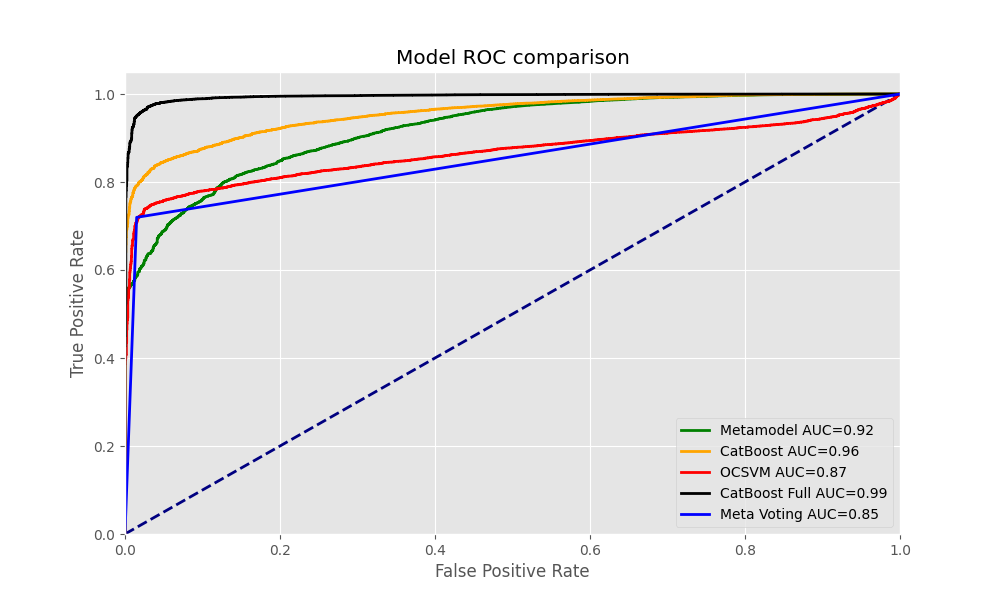

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.92      0.14      0.25      2788
           1       0.92      1.00      0.96     25915

    accuracy                           0.92     28703
   macro avg       0.92      0.57      0.60     28703
weighted avg       0.92      0.92      0.89     28703

Metamodel confusion matrix:
[[  402  2386]
 [   36 25879]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.70      0.50      0.59      2788
           1       0.95      0.98      0.96     25915

    accuracy                           0.93     28703
   macro avg       0.82      0.74      0.77     28703
weighted avg       0.92      0.93      0.93     28703

CatBoost confusion matrix:
[[ 1401  1387]
 [  597 25318]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification repo

In [17]:
multi_model_perf(y_test, [test_data['meta_y_pred'], test_data['cat_cl_pred'], test_data['ocsvm_pred'],
                       test_data['full_y_pred'], test_data['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'CatBoost Full', 'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.9,0.5])

In [18]:
print('Hardest rendition types:')
test_data['full_y_pred_lab'] = test_data['full_y_pred']>0.9
test_data[test_data.full_y_pred_lab!=test_data.target].groupby('rendition').rendition.count().sort_values().tail(15)

Hardest rendition types:


rendition
360p_black_and_white        12
1080p_low_bitrate_4         15
240p_watermark              17
360p_low_bitrate_4          18
240p_low_bitrate_4          20
1080p_watermark-345x114     20
144p                        22
144p_watermark              26
480p_low_bitrate_4          41
720p_low_bitrate_4          46
720p_watermark-345x114      49
480p_watermark-345x114      65
360p_watermark-345x114      90
240p_watermark-345x114     119
144p_watermark-345x114     166
Name: rendition, dtype: int64

In [19]:
print('Feature importance:')
importance = catboost_full.get_feature_importance(prettified=True)
importance['Feature Name']=np.array(FULL_FEATURES)[importance['Feature Id'].values.astype(np.int32)]
importance

Feature importance:


,Feature Id,Importances,Feature Name
0,0,31.267142,size_dimension_ratio
1,2,29.595945,temporal_threshold_gaussian_difference-mean
2,3,16.555531,temporal_gaussian_difference-mean
3,4,13.209998,temporal_gaussian_mse-mean
4,1,9.371384,temporal_dct-mean


FPS Renditions


<IPython.core.display.Javascript object>


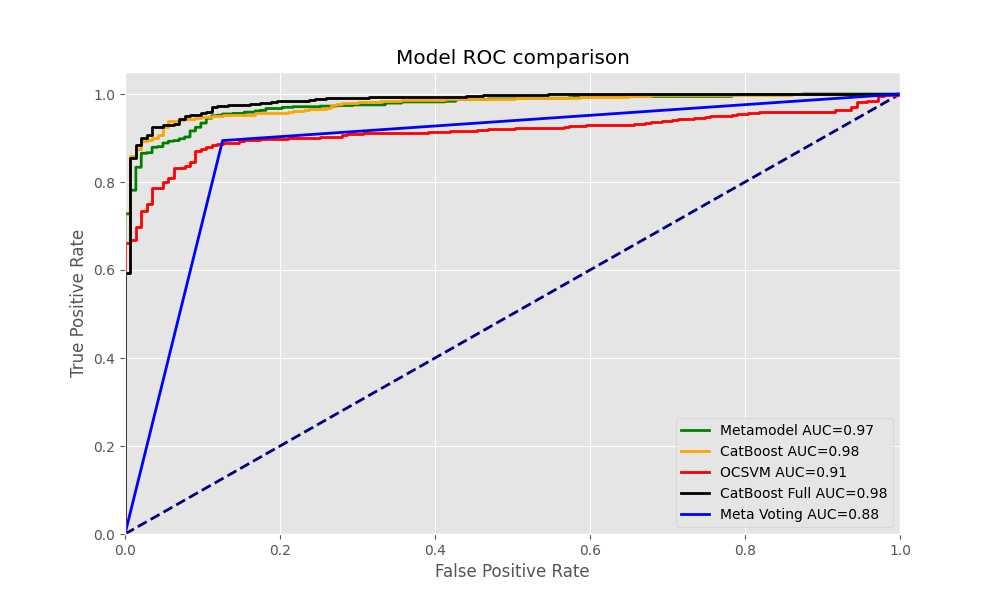

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       1.00      0.08      0.14       143
           1       0.85      1.00      0.92       727

    accuracy                           0.85       870
   macro avg       0.92      0.54      0.53       870
weighted avg       0.87      0.85      0.79       870

Metamodel confusion matrix:
[[ 11 132]
 [  0 727]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.95      0.27      0.42       143
           1       0.87      1.00      0.93       727

    accuracy                           0.88       870
   macro avg       0.91      0.63      0.67       870
weighted avg       0.89      0.88      0.85       870

CatBoost confusion matrix:
[[ 38 105]
 [  2 725]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
            

In [29]:
print('FPS Renditions')
fps_test_idx = test_data.id.str.contains('fps')
y_test_fps = test_data[fps_test_idx]['target']
multi_model_perf(y_test_fps, [test_data[fps_test_idx]['meta_y_pred'], test_data[fps_test_idx]['cat_cl_pred'], test_data[fps_test_idx]['ocsvm_pred'],
                       test_data[fps_test_idx]['full_y_pred'], test_data[fps_test_idx]['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'CatBoost Full', 'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.9,0.5])

In [52]:
tp = np.sum(np.logical_and(test_data['full_y_pred_lab']==y_test, y_test==1))
fp = np.sum(np.logical_and(test_data['full_y_pred_lab']==1,y_test==0))
precision = tp/(tp+fp)
recall = tp/np.sum(y_test==1)
precision, recall

(0.9968563469956228, 0.9666602353849122)

In [51]:
np.sum(y_test==1)

25915

In [49]:
test_data[test_data['full_y_pred_lab']==y_test].shape

(27760, 75)